### Detecting Phishing URLs by performing feature extraction and using Logistic Regression and Support Vector Machine models

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
# Natural Language Toolkit for tokenizing URL, word lemmatization
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import tensorflow as tf
from sklearn.utils import shuffle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
# uploading dataset file
from google.colab import files
file = files.upload()

Saving phishing_site_urls.csv to phishing_site_urls.csv


In [4]:
# reading the data from the csv (dataset) file
data = pd.read_csv('phishing_site_urls.csv')
print('First 10 data entries:')
data.head(10)

First 10 data entries:


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
5,smilesvoegol.servebbs.org/voegol.php,bad
6,premierpaymentprocessing.com/includes/boleto-2...,bad
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad
8,super1000.info/docs,bad
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad


In [5]:
# Dataframe information
print('Dataframe Information:\n')
data.info()

Dataframe Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


Bar graph, before changing anything in the dataset, for number of good and bad urls:



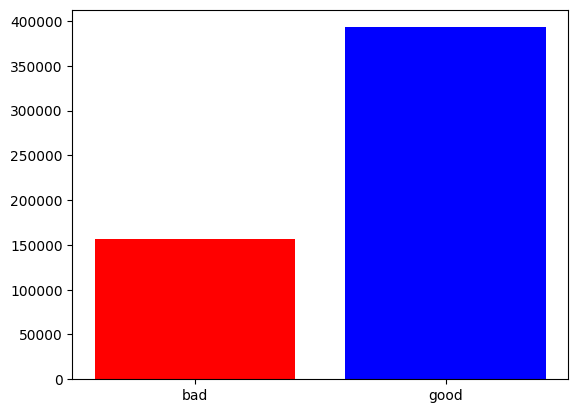

In [6]:
# Plotting bar graph for better understanding of original data set, that is number of good and bad urls.
print('Bar graph, before changing anything in the dataset, for number of good and bad urls:\n')
x = data.Label.unique()
y = [data[data.Label == 'bad'].count()[0], data[data.Label == 'good'].count()[0]]
plt.bar(x, y, color=['red', 'blue']);

In [7]:
# Checking and Removing nulls from the dataset
null = data.isnull().sum()
data.dropna(inplace=True)
print(null)

URL      0
Label    0
dtype: int64


In [8]:
# Removing duplicates from the dataset
duplicates = data.URL.duplicated().sum()
print('Number of duplicate URLs: ', duplicates)

if duplicates>0:
  data.drop(data[data.URL.duplicated() == True].index, inplace = True)
  data.reset_index(drop = True)

Number of duplicate URLs:  42151


In [9]:
# Tokenizing each url
data['clean_url'] = data.URL.astype(str)
tokenizer = RegexpTokenizer(r'[A-Za-z0-9]+')
data['clean_url'] = data.clean_url.map(lambda x: tokenizer.tokenize(x))

In [10]:
# Word Lemmatization and handling stopword
stopword = list(set(stopwords.words("english")))
lemmatizer = WordNetLemmatizer()
data['lem_url'] = data['clean_url'].map(lambda x: [lemmatizer.lemmatize(word) for word in x if word not in stopword])

In [11]:
# dataframe after feature extraction
data.sample(10)

,URL,Label,clean_url,lem_url
100153,exohi-sarti.gr/images/boasupport/bank-account/...,bad,"[exohi, sarti, gr, images, boasupport, bank, a...","[exohi, sarti, gr, image, boasupport, bank, ac..."
258240,whois.domaintools.com/awimusic.com,good,"[whois, domaintools, com, awimusic, com]","[whois, domaintools, com, awimusic, com]"
120005,acsicr.com/wp/wp-content/context/deactivation....,bad,"[acsicr, com, wp, wp, content, context, deacti...","[acsicr, com, wp, wp, content, context, deacti..."
484923,4xoi41aoxe.jawutoxpp.com/99t499zh24\nvellejare...,bad,"[4xoi41aoxe, jawutoxpp, com, 99t499zh24, nvell...","[4xoi41aoxe, jawutoxpp, com, 99t499zh24, nvell..."
44877,www380.paypal.ca.33741.securessl-130.mx/js/web...,bad,"[www380, paypal, ca, 33741, securessl, 130, mx...","[www380, paypal, ca, 33741, securessl, 130, mx..."
260544,wn.com/Henry_Starnes,good,"[wn, com, Henry, Starnes]","[wn, com, Henry, Starnes]"
415910,pornstar.com/star.php?id=2,good,"[pornstar, com, star, php, id, 2]","[pornstar, com, star, php, id, 2]"
465137,wireimage.com/CelebListing.asp?cval=M,good,"[wireimage, com, CelebListing, asp, cval, M]","[wireimage, com, CelebListing, asp, cval, M]"
154438,ca.linkedin.com/in/francoisgascon,good,"[ca, linkedin, com, in, francoisgascon]","[ca, linkedin, com, francoisgascon]"
167005,duckduckgo.com/1/c/Canadian_journalists,good,"[duckduckgo, com, 1, c, Canadian, journalists]","[duckduckgo, com, 1, c, Canadian, journalist]"


In [12]:
# Vectorizing using TF-IDF
# initializing TF-IDF object
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=10)

# transforming the data into matrix of TF-IDF matrix
unigramdataGet = vectorizer.fit_transform(data['lem_url'].apply(lambda x: ' '.join(x)))
unigramdataGet = unigramdataGet.toarray()

# creating a new dataframe, column names are set to words
vocab = vectorizer.get_feature_names_out()
x = pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
x[x>0] = 1

In [13]:
# Using Count Vectorizer as using it as a dataset, produces higher accuracy than TF-IDF
cv = CountVectorizer()
feature = cv.fit_transform(data.lem_url.astype('str'))

In [14]:
# getting Label, good or bad, and converting them to either 0 or 1
y = data.Label
y = np.where(y=='bad',0,1)

In [15]:
# Splitting data into training and testing dataset
X_train_TFIDF, X_test_TFIDF, y_train_TFIDF, y_test_TFIDF = train_test_split(unigramdataGet, y, test_size=0.2, random_state=42)
X_train_CV, X_test_CV, y_train_CV, y_test_CV = train_test_split(feature, y, test_size=0.2, random_state=42)

In [16]:
LR_acc = []

# implementing Logistic Regression model for TFIDF
LR_model_TFIDF = LogisticRegression()
LR_model_TFIDF.fit(X_train_TFIDF, y_train_TFIDF)
y_pred_TFIDF = LR_model_TFIDF.predict(X_test_TFIDF)
LR_accuracy_TFIDF = accuracy_score(y_test_TFIDF, y_pred_TFIDF)
LR_acc.append(LR_accuracy_TFIDF)
print('Logistic Regression for TF-IDF, Accuracy:', LR_accuracy_TFIDF)

# implementing Logistic Regression model for CountVectorizer
LR_model_CV = LogisticRegression(max_iter=100)
LR_model_CV.fit(X_train_CV, y_train_CV)
y_pred_CV = LR_model_CV.predict(X_test_CV)
LR_accuracy_CV = accuracy_score(y_test_CV, y_pred_CV)
LR_acc.append(LR_accuracy_CV)
print('Logistic Regression for Count Vectorizer, Accuracy:', LR_accuracy_CV)

Logistic Regression for TF-IDF, Accuracy: 0.8068987273139522
Logistic Regression for Count Vectorizer, Accuracy: 0.9632291327793058


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
svm_acc = []

# implementing SVM for TF-IDF
svm_TFIDF = LinearSVC().fit(X_train_TFIDF, y_train_TFIDF)
y_pred_TFIDF = svm_TFIDF.predict(X_test_TFIDF)
svc_accuracy_TFIDF = accuracy_score(y_test_TFIDF, y_pred_TFIDF)
svm_acc.append(svc_accuracy_TFIDF)
print('SVC Accuracy for TF-IDF:', svc_accuracy_TFIDF)

# implementing SVM for TF-IDF
svm_CV = LinearSVC().fit(X_train_CV, y_train_CV)
y_pred_CV = svm_CV.predict(X_test_CV)
svc_accuracy_CV = accuracy_score(y_test_CV, y_pred_CV)
svm_acc.append(svc_accuracy_CV)
print('SVC Accuracy for Count Vectorizer:', svc_accuracy_CV)

SVC Accuracy for TF-IDF: 0.8068691528899141
SVC Accuracy for Count Vectorizer: 0.9710564970080541


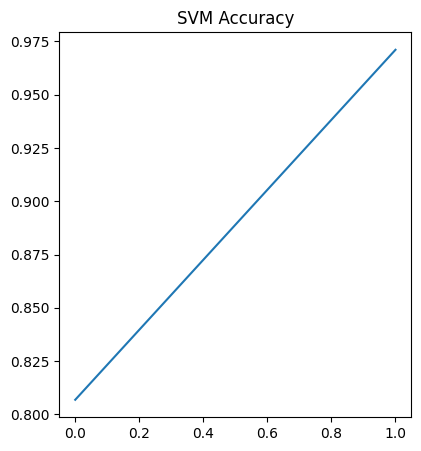

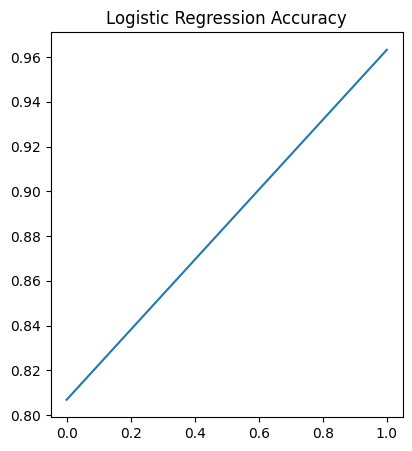

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(svm_acc)
plt.title('SVM Accuracy')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(LR_acc)
plt.title('Logistic Regression Accuracy')
plt.show()